In [1]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import torch
import random
from sklearn.manifold import TSNE
from sklearn.metrics import *
from matplotlib import pyplot as plt
import numpy as np
import sqlite3
from scipy.stats import ttest_ind

In [2]:
def diameter(pts):
    # need at least 3 points to construct the convex hull
    if pts.shape[0] <= 1:
        return 0
    if pts.shape[0] == 2:
        return ((pts[0] - pts[1])**2).sum()
    # two points which are fruthest apart will occur as vertices of the convex hull
    hull = spatial.ConvexHull(pts)
    candidates = pts[spatial.ConvexHull(pts).vertices]
    return spatial.distance_matrix(candidates, candidates).max()

def dunn_index(pts, labels, centroids):
    # O(k n log(n)) with k clusters and n points; better performance with more even clusters
    max_intracluster_dist = max(diameter(pts[labels==i]) for i in np.unique(labels))
    # O(k^2) with k clusters; can be reduced to O(k log(k))
    # get pairwise distances between centroids
    cluster_dmat = spatial.distance_matrix(centroids, centroids)
    # fill diagonal with +inf: ignore zero distance to self in "min" computation
    np.fill_diagonal(cluster_dmat, np.inf)
    min_intercluster_dist = cluster_sizes.min()
    return min_intercluster_dist / max_intracluster_dist

In [3]:
con = sqlite3.connect('witt.db')

In [4]:
cur = con.cursor()

In [5]:
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category ORDER BY size DESC')

In [6]:
cur.fetchall()

[('software', 4104),
 ('library', 2101),
 ('framework', 1578),
 ('tool', 1288),
 ('null', 1099),
 ('systems', 812),
 ('programming-language', 687),
 ('platform', 646),
 ('company', 634),
 ('language', 587),
 ('class', 478),
 ('service', 449),
 ('plugin', 430),
 ('component', 420),
 ('application', 395),
 ('api', 395),
 ('program', 374),
 ('extension', 349),
 ('functions', 336),
 ('file-format', 318),
 ('os', 314),
 ('method', 313),
 ('engine', 306),
 ('protocols', 293),
 ('server', 285),
 ('ide', 274),
 ('project', 268),
 ('interface', 263),
 ('format', 249),
 ('feature', 231),
 ('web-framework', 226),
 ('standard', 221),
 ('technique', 220),
 ('algorithm', 208),
 ('module', 204),
 ('website', 203),
 ('environment', 198),
 ('utility', 194),
 ('database', 190),
 ('toolkit', 187),
 ('programming', 184),
 ('product', 183),
 ('editor', 173),
 ('technology', 164),
 ('file', 160),
 ('manager', 158),
 ('way', 156),
 ('cms', 156),
 ('solution', 150),
 ('term', 149),
 ('specification', 148),
 (

In [7]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "programming-language"')
results = cur.fetchall()
results

[('javascript',),
 ('java',),
 ('c#',),
 ('php',),
 ('python',),
 ('c++',),
 ('sql',),
 ('objective-c',),
 ('c',),
 ('r',),
 ('ruby',),
 ('swift',),
 ('vb.net',),
 ('vba',),
 ('python-3.x',),
 ('python-2.7',),
 ('scala',),
 ('excel-vba',),
 ('swing',),
 ('linq',),
 ('perl',),
 ('powershell',),
 ('typescript',),
 ('c++11',),
 ('actionscript-3',),
 ('haskell',),
 ('xslt',),
 ('dom',),
 ('assembly',),
 ('c#-4.0',),
 ('awk',),
 ('groovy',),
 ('sed',),
 ('swift3',),
 ('vbscript',),
 ('clojure',),
 ('linq-to-sql',),
 ('lua',),
 ('ecmascript-6',),
 ('java-8',),
 ('coffeescript',),
 ('vb6',),
 ('access-vba',),
 ('actionscript',),
 ('swift2',),
 ('fortran',),
 ('erlang',),
 ('dart',),
 ('qml',),
 ('applescript',),
 ('scheme',),
 ('lisp',),
 ('elixir',),
 ('glsl',),
 ('jstl',),
 ('ocaml',),
 ('linq-to-xml',),
 ('c++14',),
 ('processing',),
 ('shader',),
 ('common-lisp',),
 ('xslt-1.0',),
 ('vhdl',),
 ('racket',),
 ('wolfram-mathematica',),
 ('verilog',),
 ('julia-lang',),
 ('elisp',),
 ('sparql'

In [8]:
results = np.array(results).squeeze()

In [9]:
results

array(['javascript', 'java', 'c#', 'php', 'python', 'c++', 'sql',
       'objective-c', 'c', 'r', 'ruby', 'swift', 'vb.net', 'vba',
       'python-3.x', 'python-2.7', 'scala', 'excel-vba', 'swing', 'linq',
       'perl', 'powershell', 'typescript', 'c++11', 'actionscript-3',
       'haskell', 'xslt', 'dom', 'assembly', 'c#-4.0', 'awk', 'groovy',
       'sed', 'swift3', 'vbscript', 'clojure', 'linq-to-sql', 'lua',
       'ecmascript-6', 'java-8', 'coffeescript', 'vb6', 'access-vba',
       'actionscript', 'swift2', 'fortran', 'erlang', 'dart', 'qml',
       'applescript', 'scheme', 'lisp', 'elixir', 'glsl', 'jstl', 'ocaml',
       'linq-to-xml', 'c++14', 'processing', 'shader', 'common-lisp',
       'xslt-1.0', 'vhdl', 'racket', 'wolfram-mathematica', 'verilog',
       'julia-lang', 'elisp', 'sparql', 'xquery', 'c#-3.0', 'haml',
       'word-vba', 'facebook-fql', 'xslt-2.0', 'cython', 'aop',
       'matlab-figure', 'python-3.5', 'java-7', 'aspectj', 'python-3.4',
       'el', 'plpgsql',

In [10]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "website"')
results2 = cur.fetchall()
results2 = np.array(results2).squeeze()
results2

array(['google-maps', 'amazon-web-services', 'google-maps-api-3',
       'amazon-s3', 'gwt', 'google-analytics', 'youtube', 'google-api',
       'google-drive-sdk', 'gmail', 'google-cloud-platform', 'bitbucket',
       'gitlab', 'google-plus', 'google-cloud-storage', 'prism',
       'openstreetmap', 'google-chrome-app', 'html5-audio', 'blogger',
       'tumblr', 'amazon-cloudfront', 'google-apps', 'jsfiddle',
       'google-maps-api-2', 'google-fusion-tables', 'onedrive', 'vimeo',
       'wiki', 'google-form', 'marker', 'google-translate', 'ebay',
       'forum', 'google-webmaster-tools', 'yahoo-finance', 'bing',
       'yahoo-api', 'reddit', 'zope', 'portal', 'freebase', 'amazon-mws',
       'google-search-api', 'google-apps-marketplace',
       'google-geocoding-api', 'universal-analytics', 'tweets', 'twitch',
       'skin', 'gcp', 'mechanicalturk', 'google-analytics-v4', 'skinning',
       'article', 'imgur', 'hotmail', 'chrome-web-store', 'skydrive',
       'aws-code-deploy', 'goog

In [11]:
x = results.tolist()
y = results2.tolist()
x.extend(y)
_results = x

In [12]:
_results = [x.split('-')[0] for x in _results]

In [13]:
_results = list(set(_results))

In [14]:
def get_model(model_name='bert-base-uncased', data='full'):
    path = f'../models/{data}/{model_name}/checkpoint-250000/'
    model = AutoModel.from_pretrained(path)
    tok = AutoTokenizer.from_pretrained(model_name)
    
    return model, tok

In [15]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [16]:
def get_model_word_vectors(model_name='bert-base-uncased', data='full'):
    vectors = []
    words = []
    
    model, tok = get_model(model_name, data)

    # Get word embeddings for every word in results using model.
    for x in _results:
        encoded_input = tok(x, return_tensors='pt')
        model_output = model(**encoded_input)

        vectors.append(mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy())
        words.append(x)

    print(len(vectors), vectors[0].shape)
    vectors = np.array(vectors)
    vectors = vectors.squeeze()
    
    print('Shape of vectors is', vectors.shape)

    return words, vectors

In [17]:
words, vectors = get_model_word_vectors()

tsne = TSNE()
vectors = tsne.fit_transform(vectors)

Some weights of the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ and are newly initial

680 (1, 768)
Shape of vectors is (680, 768)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


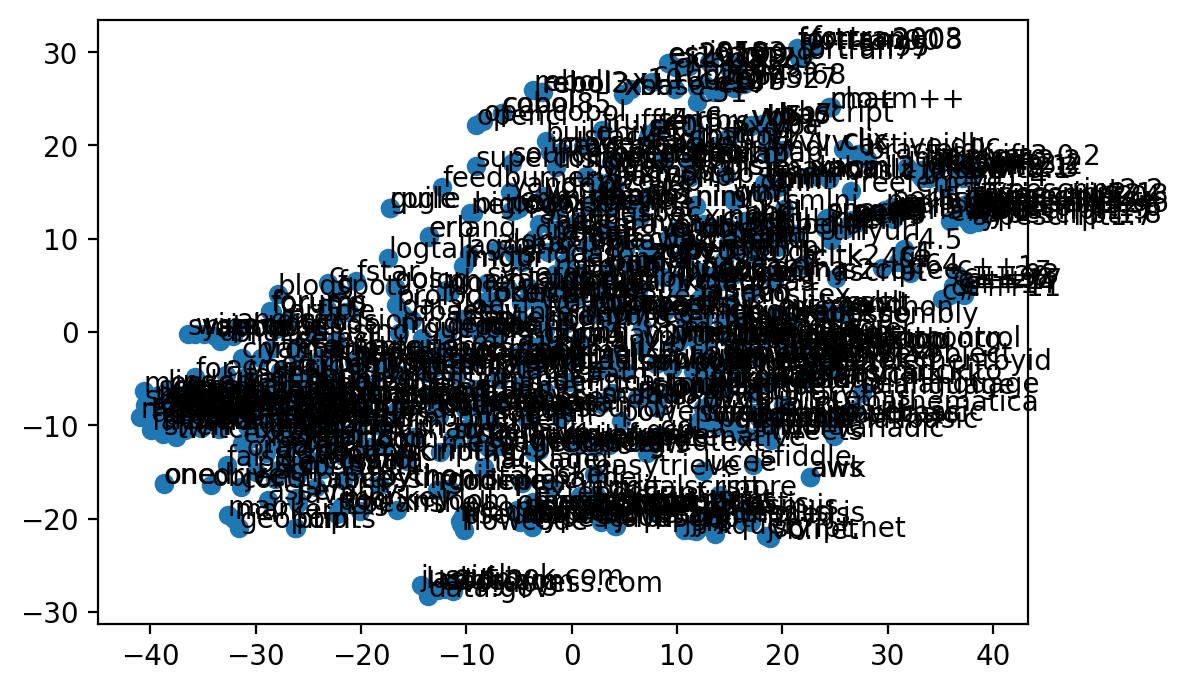

In [18]:
plt.figure(dpi=200)
plt.scatter(vectors.T[0], vectors.T[1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(vectors[i][0], vectors[i][1]))

## Do this with a subset

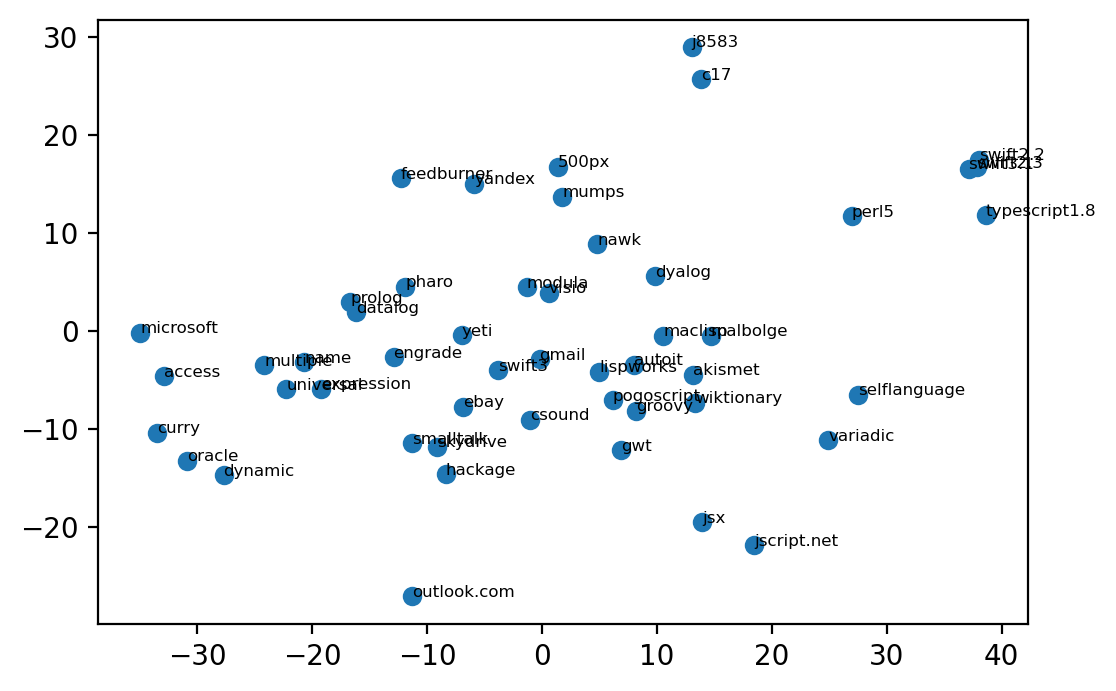

In [19]:
plt.figure(dpi=200)
plt.scatter(vectors[:50].T[0], vectors[:50].T[1])
for i, word in enumerate(words[:50]):
    plt.annotate(word, xy=(vectors[:50][i][0], vectors[:50][i][1]), fontsize=6)

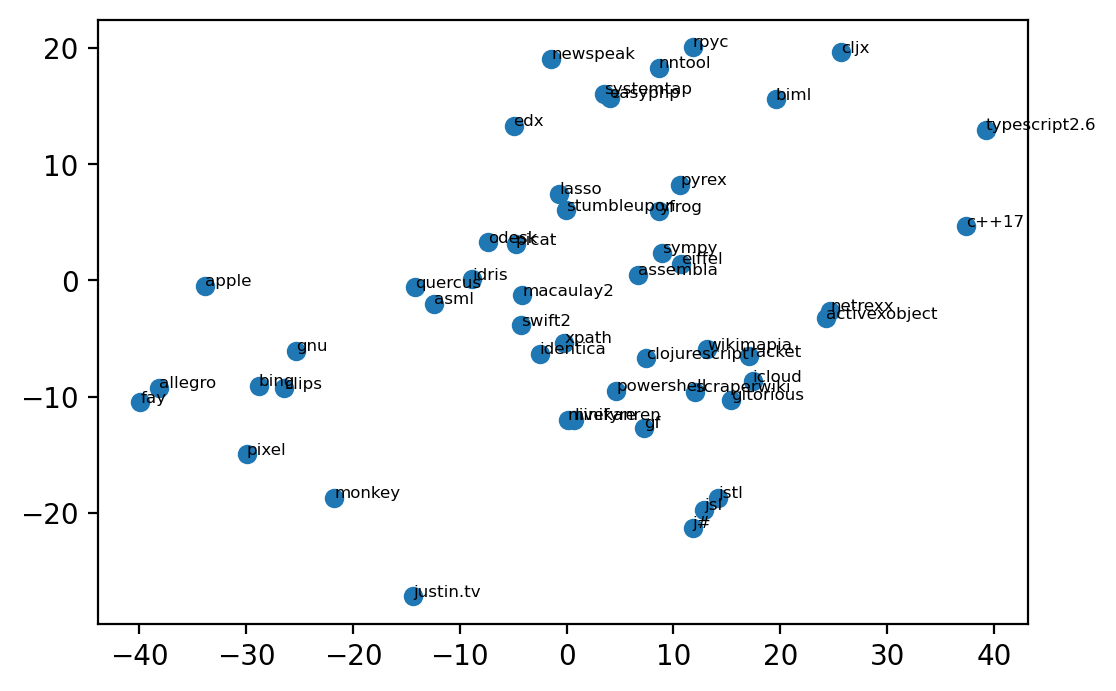

In [20]:
plt.figure(dpi=200)
plt.scatter(vectors[50:100].T[0], vectors[50:100].T[1])
for i, word in enumerate(words[50:100]):
    plt.annotate(word, xy=(vectors[50:100][i][0], vectors[50:100][i][1]), fontsize=6)

In [21]:
# Populate a mapping from category to words
cat_to_words = {}

cur = con.cursor()
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category')
categories = cur.fetchall()

for cat, size in categories:
    if size == 0:
        continue
        
    cur = con.cursor()
    cur.execute(f'SELECT Tag FROM Categories WHERE Category = "{cat}"')
    results = cur.fetchall()
    
    if len(results) > 10:
        cat_to_words[cat] = np.array(results).squeeze().tolist()

In [22]:
cat_to_words

{'.net': ['mono',
  'umbraco',
  'umbraco7',
  'customvalidator',
  'oxyplot',
  'umbraco6',
  'quickgraph',
  'umbraco5',
  'urhosharp',
  'umbraco4',
  'flourinefx',
  'nosdb'],
 '.net-class': ['x509certificate',
  'transactionscope',
  'sendkeys',
  'dataview',
  'bindingsource',
  'x509certificate2',
  'networkstream',
  'udpclient',
  'activator',
  'dispatchertimer',
  'directoryentry',
  'blockingcollection',
  'sqlparameter',
  'dynamicmethod',
  'typebuilder',
  'httptaskasynchandler',
  'inkmanager'],
 'abbreviation': ['nan',
  'ads',
  'sudo',
  'gsm',
  'geo',
  'fbconnect',
  'lcd',
  'bem',
  'lampp',
  'bde',
  'hdd',
  'nul',
  'ransac',
  'dismax',
  'obex',
  'css-parsing',
  'mbcs',
  'npp',
  'seccomp',
  'vin',
  'nacl-cryptography',
  'u3d',
  'brep',
  'txf',
  'bcg',
  'dvb-t',
  'vigra'],
 'ability': ['multithreading',
  'reflection',
  'overloading',
  'scalability',
  'method-overloading',
  'introspection',
  'function-overloading',
  'connectivity',
  'self

In [23]:
def embed_words(words: list, model, tok):
    vectors = []

    for x in words:
        encoded_input = tok(x, return_tensors='pt')
        model_output = model(**encoded_input)

        vectors.append(mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy())

    return np.array(vectors).squeeze()

In [24]:
def get_labeled_dataset(vec1: np.ndarray, vec2: np.ndarray):
    """
    Create a binary dataset from two sets of vectors, each for a different category.
    """
    return np.concatenate((vec1, vec2)), np.concatenate((np.zeros((len(vec1))), np.ones((len(vec2)))))

In [25]:
def get_dataset_from_multi_vectors(vectors: list):
    """
    Get a multi-class dataset from multiple vectors, each representing 
    a category.
    """
    X = []
    y = []
    
    c = 0
    for v in vectors:
        X.extend(v)
        y.extend([c] * len(v))
        c += 1
    
    return X, y

In [26]:
def evaluate_model(model_name='bert-base-uncased', data='full'):
    """
    Returns the Calinski-Harabasz metric for a model, using the multi-class
    classification approach.
    """
    model, tok = get_model(model_name, data)
    bar = tqdm(total=len(cat_to_words))

    vectors = []
    for cat, words in cat_to_words.items():
        vectors.append(embed_words(words, model, tok))
        bar.update(1)

    X, y = get_dataset_from_multi_vectors(vectors)
    return calinski_harabasz_score(X, y)

In [28]:
evaluate_model('bert-base-uncased', 'so-only')

Some weights of the model checkpoint at ../models/so-only/bert-base-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/so-only/bert-base-uncased/checkpoint-250000/ and are newly i

  0%|          | 0/396 [00:00<?, ?it/s]

4.94219522367942

In [27]:
evaluate_model('bert-base-uncased', 'full')

Some weights of the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ and are newly initial

  0%|          | 0/396 [00:00<?, ?it/s]

4.5136637762904845

In [29]:
evaluate_model('bert-large-uncased', 'so-only')

Some weights of the model checkpoint at ../models/so-only/bert-large-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/so-only/bert-large-uncased/checkpoint-250000/ and are newly

  0%|          | 0/396 [00:00<?, ?it/s]

899.2868681347296

In [32]:
evaluate_model('bert-large-uncased', 'full')

Some weights of the model checkpoint at ../models/full/bert-large-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/full/bert-large-uncased/checkpoint-250000/ and are newly initi

  0%|          | 0/396 [00:00<?, ?it/s]

1909.1576699148177

In [36]:
evaluate_model('distilbert-base-uncased', 'so-only')

Some weights of the model checkpoint at ../models/so-only/distilbert-base-uncased/checkpoint-250000/ were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/396 [00:00<?, ?it/s]

5.2106274172046785

In [37]:
evaluate_model('distilbert-base-uncased', 'full')

Some weights of the model checkpoint at ../models/full/distilbert-base-uncased/checkpoint-250000/ were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/396 [00:00<?, ?it/s]

5.191142036435144

In [39]:
def intrinsic_eval(model_name, data):
    bar = tqdm(total=100)
    scores = []
    counter = 0
    
    model, tok = get_model(model_name, data)
    
    for cat1, words1 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
        for cat2, words2 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
            if cat1 < cat2:
                vec1 = embed_words(words1, model, tok)
                vec2 = embed_words(words2, model, tok)

                X, y = get_labeled_dataset(vec1, vec2)
                score = calinski_harabasz_score(X, y)
                scores.append(score)
                counter += 1

                if counter == 100:
                    return scores

                bar.update(1)
    
    return scores

In [40]:
intrinsic_eval('bert-base-uncased', 'so-only')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/so-only/bert-base-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/so-only/bert-base-uncased/checkpoint-250000/ and are newly i

[2.3760289118968063,
 6.870770255714551,
 1.9572893647472054,
 2.1387166845701575,
 1.9765606674706477,
 3.3167342436601275,
 2.387613963181702,
 6.061695736691156,
 4.925090168510272,
 4.079302492220373,
 2.9017339543965046,
 2.923663103634177,
 1.8611837736073722,
 2.6173016003718796,
 2.2708776864179323,
 4.031929064373177,
 4.008503346858311,
 9.551311781079873,
 4.772683381659029,
 3.4381575471877364,
 6.3006746408003265,
 3.0565905663968835,
 5.549616775079384,
 5.474363419469655,
 5.935781299471522,
 1.7492862755028684,
 1.5186745855161063,
 3.2803007226957694,
 2.768425975836675,
 2.956982601937741,
 5.165958460563553,
 2.0463526711454487,
 7.839534574254536,
 2.4079563473945287,
 2.123787907849783,
 4.828976711872872,
 1.710206665993226,
 4.42486417211011,
 1.5752709283314204,
 7.566591894673164,
 3.3553725296093355,
 4.936433581476607,
 3.021588521680174,
 1.8141670244143773,
 1.84267465538153,
 4.840438991477555,
 3.553161708221181,
 1.7454018258573596,
 4.399814957952943,
 

In [41]:
intrinsic_eval('bert-base-uncased', 'full')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ and are newly initial

[2.2172001175354707,
 2.4708058309375285,
 0.9462273682477755,
 3.4685071920376416,
 0.8692982527363324,
 1.4144502885170513,
 1.471429883612125,
 5.966335498664004,
 0.9784581119414358,
 1.2752832530329148,
 3.845520074020762,
 1.0020740242585537,
 2.093022711712609,
 2.655677679549495,
 0.9041480192347942,
 3.1551634880101727,
 1.645220047009143,
 2.1468034342409505,
 1.5841223123004895,
 0.7796295325904965,
 0.9972517259927162,
 0.8996112138450082,
 4.348515999039299,
 2.6486419640118304,
 2.2612413461290495,
 1.1939920033425282,
 2.3713667940965335,
 0.9585207427550269,
 1.5562011278845098,
 2.0991563966493976,
 2.428896459125641,
 1.297803942712309,
 1.047737483592096,
 0.8640836908173948,
 1.6295766671528662,
 1.6238747218655365,
 1.4619904432601418,
 1.0049054201826866,
 0.7741671640210983,
 1.6109079890969555,
 0.7982743146187198,
 1.4267832834350431,
 1.0651344911587637,
 1.050106786283803,
 1.0835066392605106,
 0.7425674829967363,
 1.7366711270458646,
 1.6714832552941028,
 1.

In [42]:
intrinsic_eval('bert-large-uncased', 'so-only')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/so-only/bert-large-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/so-only/bert-large-uncased/checkpoint-250000/ and are newly

[252.57103754824712,
 47.12299141792286,
 54.545890073205754,
 60.74158801602721,
 83.17540687073311,
 78.62677593032905,
 199.1246300497318,
 76.1751628603139,
 133.241839972731,
 76.49912002248546,
 133.0833794014526,
 96.19186457070434,
 50.92279266877938,
 49.75703356333676,
 47.696761858612646,
 193.6471035953726,
 89.80779100452293,
 53.701323368947435,
 92.90851660261166,
 90.6876883852079,
 279.1766378868051,
 78.47554851711834,
 81.85989424223922,
 385.83255216749757,
 73.10913709375583,
 78.61496876482933,
 50.292580373010345,
 334.6457594921136,
 45.43728498142244,
 55.63908866262317,
 72.78798706514198,
 150.67240479534308,
 113.84602955045065,
 60.65869652762093,
 332.6971339203443,
 72.81599671686753,
 79.5066266803801,
 81.18712509885749,
 311.5484919284706,
 224.2520074586766,
 98.41852652191636,
 49.32798823867419,
 268.441058805996,
 82.1365957599898,
 74.81235456353076,
 73.1142536773097,
 316.6798204228683,
 185.06963425000325,
 73.40340387477089,
 52.48088548797514

In [43]:
intrinsic_eval('bert-large-uncased', 'full')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/full/bert-large-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/full/bert-large-uncased/checkpoint-250000/ and are newly initi

[228.322553545196,
 97.03558423822649,
 102.196197976487,
 165.1726030994283,
 122.47464482329059,
 55.885135899560346,
 75.22247429510553,
 155.03420062329673,
 95.38392362419805,
 105.73986343564503,
 158.17530607355977,
 166.35709014431953,
 67.34438835659662,
 149.15592238854927,
 101.52390568093618,
 156.83567922752977,
 152.16994256725624,
 206.69074068861406,
 169.70941908645867,
 146.1892120499983,
 105.83836005723121,
 139.74991258116688,
 71.03685600967921,
 101.53049780491179,
 135.2035819467751,
 144.61867858006335,
 121.81664302902077,
 291.4601507222699,
 166.46856025172607,
 168.72285125533662,
 160.34031470415434,
 165.2230603247907,
 112.35409837550255,
 85.52803410825925,
 170.23287570219424,
 120.23439646616538,
 367.8326637156101,
 153.07285083336296,
 63.56615066967053,
 159.3560996047794,
 107.02772806119852,
 110.28380768560498,
 109.03702335200032,
 144.1110189725035,
 192.92546469130073,
 93.00441465888017,
 153.4069811770017,
 99.75398028694859,
 144.621976199

In [4]:
bert_large_full = [228.322553545196,
 97.03558423822649,
 102.196197976487,
 165.1726030994283,
 122.47464482329059,
 55.885135899560346,
 75.22247429510553,
 155.03420062329673,
 95.38392362419805,
 105.73986343564503,
 158.17530607355977,
 166.35709014431953,
 67.34438835659662,
 149.15592238854927,
 101.52390568093618,
 156.83567922752977,
 152.16994256725624,
 206.69074068861406,
 169.70941908645867,
 146.1892120499983,
 105.83836005723121,
 139.74991258116688,
 71.03685600967921,
 101.53049780491179,
 135.2035819467751,
 144.61867858006335,
 121.81664302902077,
 291.4601507222699,
 166.46856025172607,
 168.72285125533662,
 160.34031470415434,
 165.2230603247907,
 112.35409837550255,
 85.52803410825925,
 170.23287570219424,
 120.23439646616538,
 367.8326637156101,
 153.07285083336296,
 63.56615066967053,
 159.3560996047794,
 107.02772806119852,
 110.28380768560498,
 109.03702335200032,
 144.1110189725035,
 192.92546469130073,
 93.00441465888017,
 153.4069811770017,
 99.75398028694859,
 144.62197619906237,
 100.15900956293724,
 180.44618829841914,
 149.85219402497552,
 108.59103814309016,
 108.06043383416662,
 141.74744162915448,
 145.8955620638108,
 140.73895266594232,
 68.12696392306363,
 94.14535323418951,
 76.84481068995095,
 66.24821633495766,
 88.70999290100356,
 70.53027169133769,
 95.07580558732677,
 182.23122370444645,
 76.75666926424776,
 115.85611427923403,
 72.53206170005494,
 79.90580512042084,
 141.61418060656857,
 151.10070887762586,
 102.46063598959978,
 62.262391216590395,
 105.67362228984983,
 148.72536933896933,
 100.77156487925129,
 66.14833021051344,
 377.6532265429075,
 116.15708587550957,
 159.01812113421198,
 145.0959359549301,
 200.0412677719409,
 102.24134616429468,
 90.52786730985734,
 172.20482628414916,
 157.80438145255758,
 92.14153621368551,
 139.70957331779172,
 123.37703158047917,
 158.40988626153845,
 171.78772251638998,
 110.91455637222859,
 197.28101520920262,
 160.17890081724713,
 103.75301258027808,
 106.54785744733975,
 164.2673920841347,
 106.76817393258752,
 77.50134400288394,
 71.0187205606862]

bert_large_so_only = [252.57103754824712,
 47.12299141792286,
 54.545890073205754,
 60.74158801602721,
 83.17540687073311,
 78.62677593032905,
 199.1246300497318,
 76.1751628603139,
 133.241839972731,
 76.49912002248546,
 133.0833794014526,
 96.19186457070434,
 50.92279266877938,
 49.75703356333676,
 47.696761858612646,
 193.6471035953726,
 89.80779100452293,
 53.701323368947435,
 92.90851660261166,
 90.6876883852079,
 279.1766378868051,
 78.47554851711834,
 81.85989424223922,
 385.83255216749757,
 73.10913709375583,
 78.61496876482933,
 50.292580373010345,
 334.6457594921136,
 45.43728498142244,
 55.63908866262317,
 72.78798706514198,
 150.67240479534308,
 113.84602955045065,
 60.65869652762093,
 332.6971339203443,
 72.81599671686753,
 79.5066266803801,
 81.18712509885749,
 311.5484919284706,
 224.2520074586766,
 98.41852652191636,
 49.32798823867419,
 268.441058805996,
 82.1365957599898,
 74.81235456353076,
 73.1142536773097,
 316.6798204228683,
 185.06963425000325,
 73.40340387477089,
 52.480885487975144,
 86.68702830983116,
 79.32342886638466,
 80.11188584289185,
 49.055700551205206,
 75.15934645156042,
 81.80208256191676,
 320.3680854818392,
 50.72208421552939,
 45.825825899171434,
 47.735186446457014,
 360.6322319863141,
 110.42624705418682,
 82.57209397477168,
 50.944522363400374,
 75.04104795732374,
 72.57145035406319,
 89.04868233795436,
 86.50063965833563,
 74.6593092492234,
 70.5377038020091,
 107.19081972142072,
 77.25439991350714,
 61.26198008894861,
 137.80951308801062,
 101.37551375410415,
 85.48224768225465,
 56.695653666913756,
 77.76634540392095,
 95.48538039806344,
 70.77530679276401,
 74.80209952205338,
 286.80380302158596,
 52.91344808265109,
 40.57289720576922,
 47.99812115258794,
 56.95254780576695,
 126.01000679737609,
 89.55934007930843,
 75.42080307001034,
 54.45134568351695,
 194.87666096049048,
 75.71713229913368,
 124.66590988082258,
 63.839125336963825,
 81.09121832074813,
 77.81877077887329,
 53.98565395262658,
 48.000861512348074,
 91.74785044837286,
 54.263966480127095]

ttest_ind(bert_large_full, bert_large_so_only, equal_var=False)

Ttest_indResult(statistic=2.4069299224543608, pvalue=0.017144624307458164)

In [44]:
intrinsic_eval('distilbert-base-uncased', 'so-only')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/so-only/distilbert-base-uncased/checkpoint-250000/ were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[11.467831700076982,
 2.3729176464734834,
 2.6058295419822524,
 2.6637608180755126,
 6.752727509888508,
 1.3846644494514162,
 3.4216251057723843,
 3.424937222926177,
 1.2925717203503764,
 2.108143823883151,
 2.1999279397780804,
 1.896830394144177,
 2.791227915635333,
 5.622623478124343,
 2.02460703439659,
 3.5795416522033934,
 6.551996134753635,
 4.017716344020653,
 3.6857703287985846,
 2.17681383416552,
 2.082598608374163,
 4.7399331949857135,
 4.966971334212047,
 4.787313655668846,
 3.34597915711121,
 2.249252207892622,
 2.5301507834801873,
 4.270304359282854,
 1.3480805689751287,
 2.340690393244444,
 6.397917883993995,
 9.65707184361152,
 3.2210810423341325,
 7.408469082115751,
 2.4362370910979907,
 5.106830523707968,
 1.497399337694608,
 3.7409220091741346,
 4.616327612916853,
 1.8064841260829718,
 3.5103524940423783,
 3.0724757675531853,
 4.211872105046603,
 5.314973700938622,
 17.670377477274982,
 1.960062772187351,
 5.439807068249465,
 3.0467843576988582,
 4.536588672763611,
 3.

In [45]:
intrinsic_eval('distilbert-base-uncased', 'full')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/full/distilbert-base-uncased/checkpoint-250000/ were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[9.993793460972318,
 9.404731110480366,
 8.693603974613039,
 10.8230681418127,
 7.421268213481764,
 7.5178528984284085,
 8.471268682992735,
 8.53623297154856,
 5.655995964870144,
 7.695464910581362,
 6.5978147979166275,
 7.7231674360083264,
 7.4524859300748485,
 6.062590600577923,
 5.996210315874137,
 8.71652031430778,
 9.20609728096781,
 5.465031729711638,
 8.826793011534876,
 10.624173127304742,
 6.3019539373874585,
 12.99535699319462,
 3.7494618845775136,
 9.526258936853704,
 11.838536264020997,
 7.437191115349879,
 7.112590419390391,
 4.9307245680822085,
 7.6984281247179895,
 10.252210407216653,
 6.344218939179329,
 6.383175469004225,
 6.856908827209998,
 6.438740517233295,
 7.743696084114533,
 6.22308797447729,
 6.485050506375756,
 5.269170204229974,
 8.453431629918837,
 5.413716295170321,
 9.543844818441107,
 9.198879799795241,
 6.56343689842249,
 6.107179692559824,
 6.453362237991864,
 7.990159860054195,
 7.692660851343032,
 12.306080311657995,
 6.687083221315599,
 4.70442028666

In [29]:
def compare_topics(topic1: str, topic2: str):
    v1 = embed_words(cat_to_words[topic1])
    v2 = embed_words(cat_to_words[topic2])
        
    y = [0] * len(v1)
    y.extend([1] * len(v2))
    return calinski_harabasz_score(np.concatenate((v1, v2)), y), davies_bouldin_score(np.concatenate((v1, v2)), y)

### These should be different (high CH, low DB)

In [30]:
compare_topics('web-framework', 'machine-learning')

(2.5918038679413575, 4.9714009819400955)

In [31]:
compare_topics('data-structure', 'software')

(16.65899636058501, 5.484511976301262)

In [32]:
compare_topics('software', 'null')

(20.906409562424955, 12.865706059731915)

### These should be the same (low CH, high DB)

In [33]:
compare_topics('software', 'product')

(4.835762894883836, 11.946448543948831)

In [34]:
compare_topics('library', 'framework')

(19.06320029224796, 13.701260784965822)

In [35]:
compare_topics('framework', 'api')

(7.643193172928663, 12.772781712566786)

In [36]:
compare_topics('ide', 'tool')

(21.079911739287923, 6.487847369688894)

### Compare ratios

In [37]:
def check_ratio(topic1: str, topic2: str, topic3: str):
    """
    Checks the ratio of (topic1, topic2) and (topic1, topic3). topic1 and topic2 should be
    *different*, while topic1 and topic3 should be *similar*.
    
    A good result will have *high* first value and *low* second value.
    """
    ch1, db1 = compare_topics(topic1, topic2)
    ch2, db2 = compare_topics(topic1, topic3)
    
    return ch1 / ch2, db1 / db2

In [38]:
check_ratio('software', 'null', 'product')

(4.3232908678263815, 1.0769481835878922)

In [39]:
check_ratio('ide', 'data-structure', 'tool')

(0.9435343406134941, 0.6488284227738335)

In [40]:
check_ratio('technique', 'plugin', 'algorithm')

(3.5257865560935238, 0.6217064639827096)

In [41]:
check_ratio('technique', 'ide', 'technique')

(203808319531.83215, 5.598845087199642e-08)